# Transfer Learning

In [83]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy

## Loading Data

#### Normalize images with means and std dev

In [71]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

#### Define transforms for dataloading

In [72]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)]),

    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)])
}

print("Training dataset transform :")
print(data_transforms["train"], "\n")

print("Validation dataset transform :")
print(data_transforms["val"])

Training dataset transform :
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
) 

Validation dataset transform :
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
)


#### Load dataset from folder

In [73]:
# Path to dataset
data_dir = './data/hymenoptera_data'

In [74]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./data/hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./data/hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )}


In [75]:
print(type(image_datasets["train"]))
CLASSES = image_datasets["train"].classes
print(CLASSES)

<class 'torchvision.datasets.folder.ImageFolder'>
['ants', 'bees']


#### Dataloader

In [76]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

In [77]:
images, labels = next(iter(dataloaders['train']))

print("input shape : ", images.shape)
print("classes shape : ", labels.shape)

input shape :  torch.Size([4, 3, 224, 224])
classes shape :  torch.Size([4])


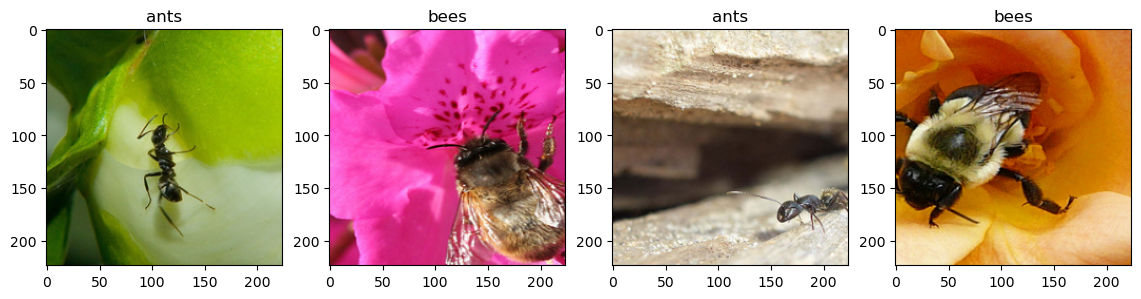

In [81]:
plt.figure(figsize=(14,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].movedim(0,-1)*std[0]+mean[0])
    plt.title(CLASSES[labels[i]])

In [84]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model